In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary

import numpy as np
import PIL
import os
import matplotlib.pyplot as plt


In [33]:
def changeFileName(path, targetName):
  fileNames = os.listdir(path)
  i = 1
  for name in fileNames:
      src = os.path.join(path, name)
      dst = targetName + '.' + str(i) + '.jpg'
      dst = os.path.join(path, dst)
      os.rename(src, dst)
      i += 1

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataDir = './dataset/AI-DATASET/data'


train_dir = os.path.join(dataDir, 'train')
test_dir = os.path.join(dataDir, 'test')

beverage_files = [f'beverage.{i}.jpg' for i in range(1, 249)]
dailynecessity_files = [f'dailynecessity.{i}.jpg' for i in range(1, 107)]
Foods_files = [f'Foods.{i}.jpg' for i in range(1, 193)]
iceCream_files = [f'iceCream.{i}.jpg' for i in range(1, 141)]
noodles_files = [f'noodles.{i}.jpg' for i in range(1, 99)]
Snack_files = [f'Snack.{i}.jpg' for i in range(1, 118)]

In [35]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'beverage' in files[0]:
            self.label = 0
        elif 'dailynecessity' in files[0]:
            self.label = 1
        elif 'Foods' in files[0]:
            self.label = 2
        elif 'iceCream' in files[0]:
            self.label = 3
        elif 'noodles' in files[0]:
            self.label = 4
        elif 'Snack' in files[0]:
            self.label = 5
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [36]:
model = torchvision.models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.cuda()
summary(model, input_size=(3,224,224))


c:\Users\kde96\.conda\envs\PyeonHaeng\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kde96\.conda\envs\PyeonHaeng\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

모델 설정 및 정상적인 파싱 확인

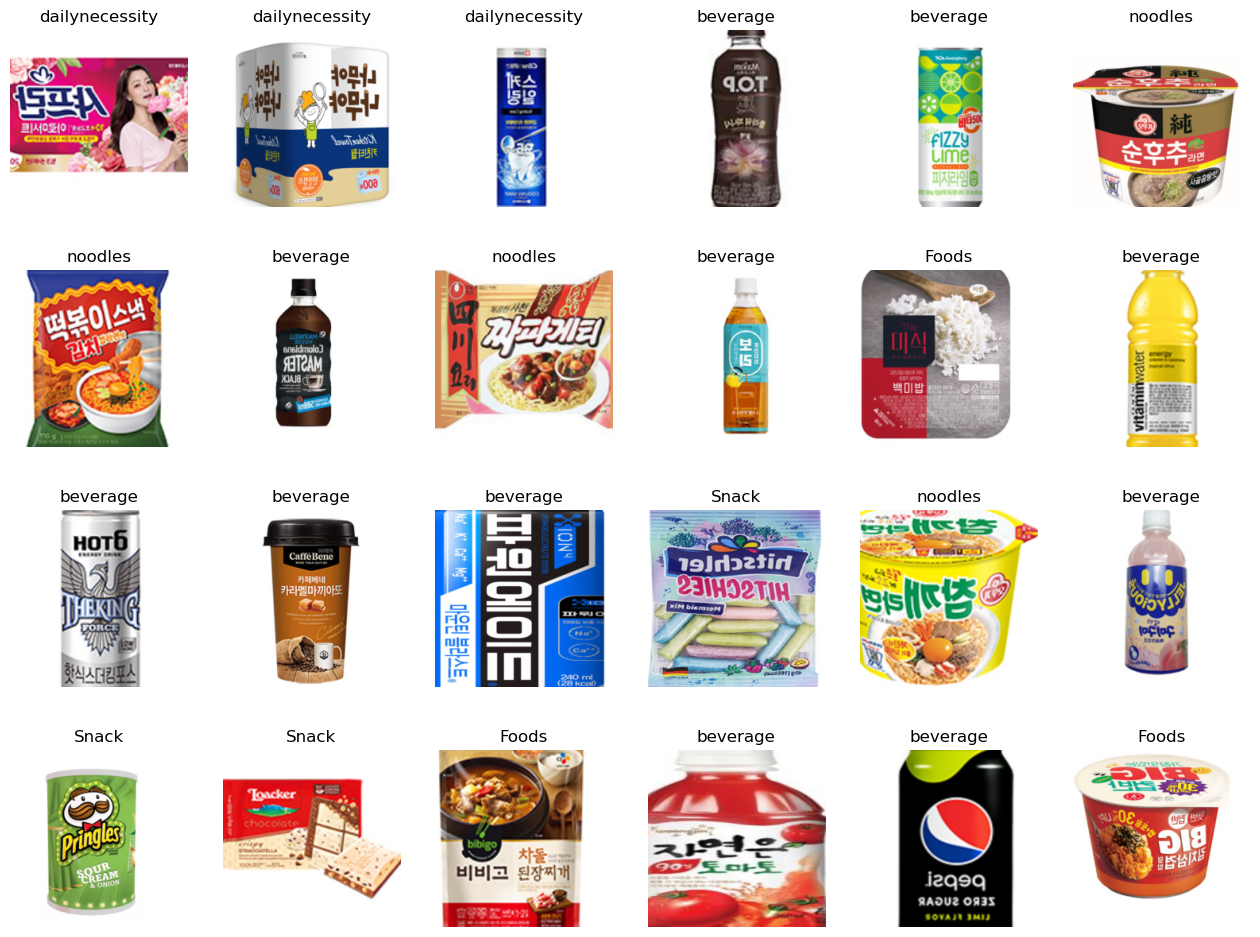

In [37]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])
train_beverage_dataset = CustomDataset(beverage_files, train_dir, transform=train_transform)
train_dailynecessity_dataset = CustomDataset(dailynecessity_files, train_dir, transform=train_transform)
train_Foods_dataset = CustomDataset(Foods_files, train_dir, transform=train_transform)
train_noodles_dataset = CustomDataset(noodles_files, train_dir, transform=train_transform)
train_Snack_dataset = CustomDataset(Snack_files, train_dir, transform=train_transform)


train_dataset = torch.utils.data.ConcatDataset([train_beverage_dataset, train_dailynecessity_dataset, train_Foods_dataset, train_noodles_dataset, train_Snack_dataset])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

samples, labels = iter(train_loader).__next__()
classes = {0:'beverage', 1:'dailynecessity', 2:'Foods', 3:'iceCream', 4: 'noodles', 5: 'Snack'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
